In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os
import datetime as dt
import numpy as np
from copy import deepcopy
import seaborn as sns
from IPython.display import display

# Load

In [2]:
files = os.listdir("data")
# Sort dates
dates = [dt.datetime.strptime(re.findall(r'\d{4}-\d{2}-\d{2}',f)[0],'%Y-%m-%d') for f in files]
dates = sorted(dates,reverse=False)
dates = [i.strftime('%Y-%m-%d') for i in dates]

dfs_raw = {d: pd.read_csv(f'data/worldometers-{d}.tsv',sep="\t") for d in dates}

# Clean

In [3]:
dfs = deepcopy(dfs_raw)
for df in dfs.values():
    for i in range(1, df.shape[1] - 1):
        # Fill nan in numerical data with 0
        df.iloc[:,i] = df.iloc[:,i].fillna(0)
    # Fill categorical nan with Other
    df.iloc[:,-1] = df.iloc[:,-1].fillna('Other')
    df.iloc[:,0] = df.iloc[:,0].fillna('Other')    

# Overall


## What is the proportion of total deaths by total recovered ?

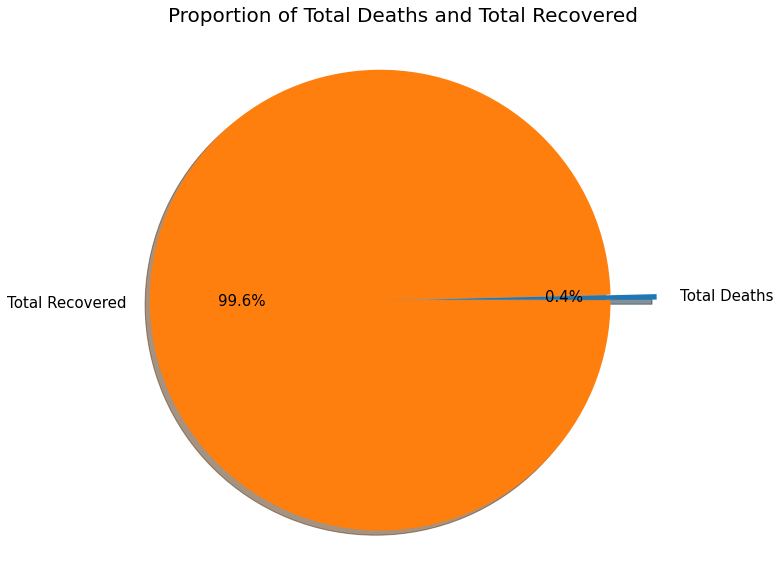

In [4]:
#Iterate over all dates and find the total deaths and total recovered 
day_deaths = np.fromiter([dfs[i]['NewDeaths'].sum() for i in dates],dtype= int)
day_recovered = np.fromiter([dfs[i]['NewRecovered'].sum() for i in dates],dtype= int)
deaths_recovered = [day_deaths.sum(),day_recovered.sum()]

#Plot pie chart to show the proportion between total deaths and total recovered
fig,ax = plt.subplots(figsize=(10,10)) 
ax.pie(deaths_recovered,
        explode=  (0.1,0.1),
        labels=['Total Deaths','Total Recovered'],
        autopct="%1.1f%%",
        startangle=0 ,
        shadow=True,
        textprops={'fontsize':15})
ax.axis('equal')
ax.set_title('Proportion of Total Deaths and Total Recovered',size=20)
plt.show() 

# Comment:
- On the total number of Recovered and Deaths: 
    - The Total Recovered is overwhelming (99%) to the Total Deaths(1%) 
    - The conduction of treating and vaccination has take its effect to the recovery of the world 

## What is the trend of Deaths and Recovered ?

/tmp/ipykernel_8226/309762900.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dates,rotation= 50,fontsize=13)
/tmp/ipykernel_8226/309762900.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dates,rotation= 50,fontsize=13)


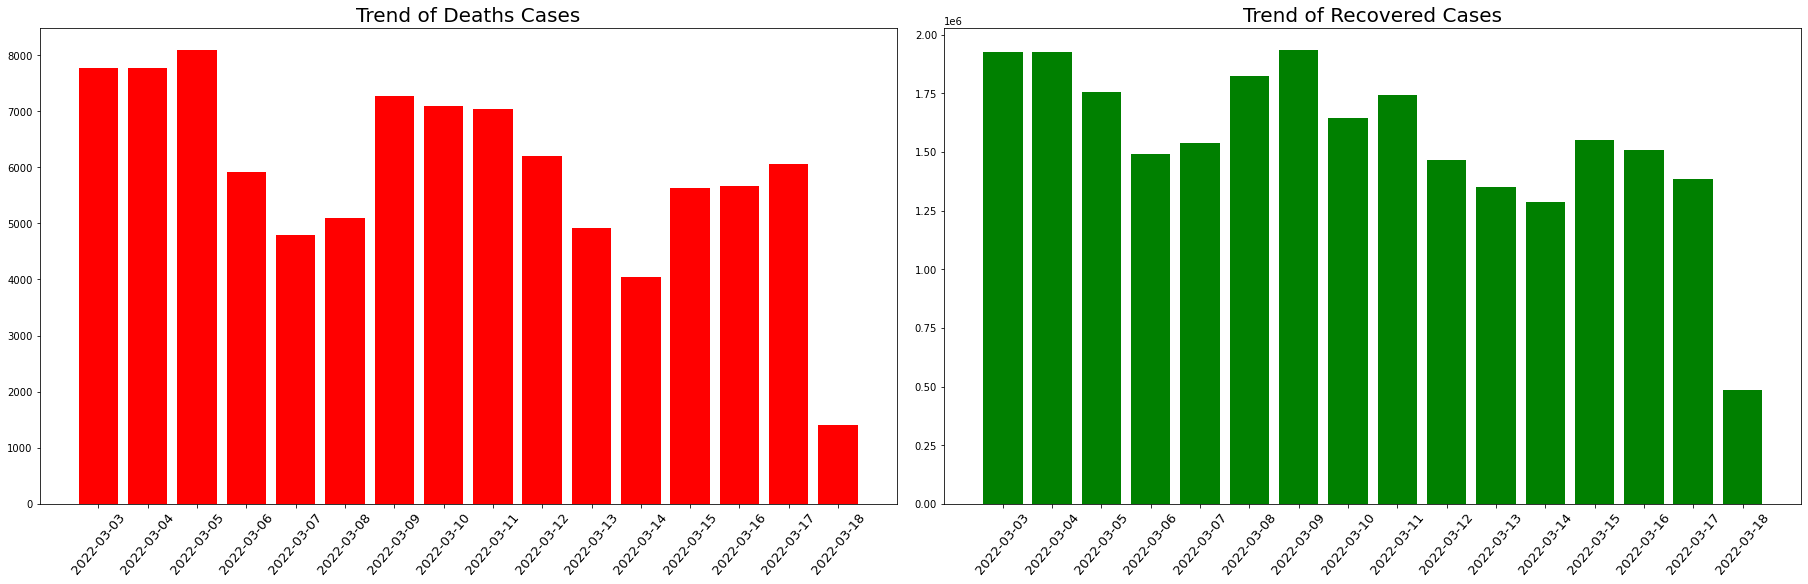

In [12]:
#Histogram to show the trend 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(25,8),constrained_layout= True)
ax1.bar(dates,day_deaths,color='r')
ax1.set_xticklabels(dates,rotation= 50,fontsize=13)
ax1.set_title('Trend of Deaths Cases',size = 20)
ax2.bar(dates,day_recovered,color='g')
ax2.set_xticklabels(dates,rotation= 50,fontsize=13)
ax2.set_title('Trend of Recovered Cases',size= 20)
plt.show()

From 03-03-2022 till 18-03-2022:
- Total Deaths keeps its balancing around 6 Million deaths. No sign of significant increase. 
- Total Recovery shows gradually surge day by day.
- The Recovery progress improves why the deaths are halting, which helps the treatment of world easier to back to normal.

## What is the relationship between Total Deaths and Total Recovered 

<Figure size 1080x1440 with 0 Axes>

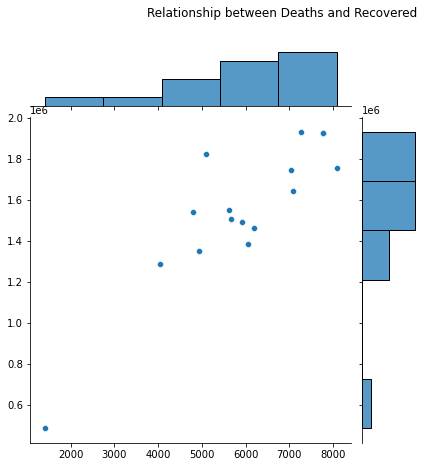

In [15]:
#Plot jointplot to show both the relationship and its distribution
plt.figure(figsize=(15,20))
sns.jointplot(x=day_deaths,y=day_recovered)
plt.title('Relationship between Deaths and Recovered',pad = 100,loc='Right')
plt.show()

In [7]:
import geoplot 
import geopandas as gpd

#Dataset to get geographical location information 
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [8]:
#Find total deaths and total recovered grouped by continent
continents_deaths = dfs[dates[-1]][['Continent','TotalDeaths']].groupby(by=['Continent']).sum()
continents_recovered = dfs[dates[-1]][['Continent','TotalRecovered']].groupby(by='Continent').sum()
new_index = {"Africa":"Africa","Asia":"Asia","Australia/Oceania":"Oceania","Europe":"Europe",
            "North America":"North America",
            "Other":"Antarctica",
            "South America":"South America"
}

#Rename continent to match the format of geoplot 
continents_deaths.rename(index=new_index,inplace=True)
continents_recovered.rename(index=new_index,inplace=True)
#Reset index 
continents_deaths = continents_deaths.reset_index(level= 0)
continents_recovered = continents_recovered.reset_index(level= 0)

In [9]:
#Join data with geographical information to show on the map 
#For total deaths
map_contients_deaths = pd.merge(world,continents_deaths,left_on='continent',right_on = 'Continent')
map_contients_deaths = map_contients_deaths.dissolve(by='continent',aggfunc='mean')
map_contients_deaths.reset_index(level=0,inplace= True)
#For total recovered
map_contients_recovered = pd.merge(world,continents_recovered,left_on='continent',right_on = 'Continent')
map_contients_recovered = map_contients_recovered.dissolve(by='continent',aggfunc='mean')
map_contients_recovered.reset_index(level=0,inplace= True)

# What is the Total Deaths and Total Recovered situation in each continent?

/home/mag/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


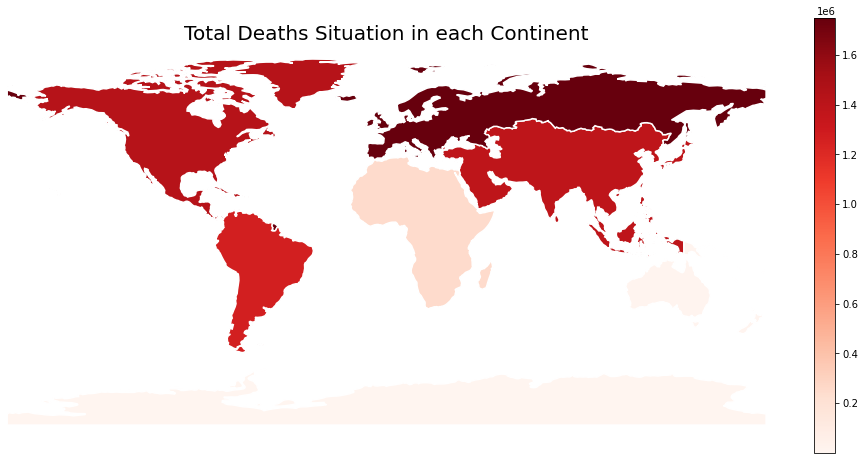

In [10]:
#Choropleht for total deaths in each continent
geoplot.choropleth(map_contients_deaths,
                    hue='TotalDeaths',
                    cmap="Reds",
                    figsize=(17,8),
                    edgecolor='white',
                    linewidth=1.5,
                    legend=True)
plt.title('Total Deaths Situation in each Continent',size=20)
plt.show()

# Comment:
- The area of Europe and Asia have the most serious Deaths : over 1.5 Million Deaths
- The runner-up is North America and South America with about 1.2 - 1.5 Million Deaths
- Africa comes with around 600.000 deaths 
- Oceania and Antarctica suffer less than 400.000 deaths in total

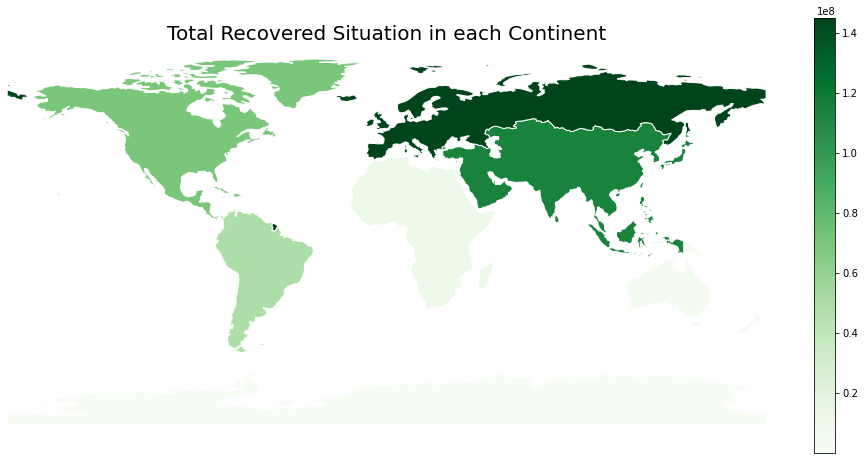

In [11]:
#Choropleth for total recovered in each continent
geoplot.choropleth(map_contients_recovered,
                    hue='TotalRecovered',
                    cmap="Greens",
                    figsize=(17,8),
                    edgecolor='white',
                    legend=True)
plt.title('Total Recovered Situation in each Continent',size=20)
plt.show()


# Comment: 
- While Europe and Asis have the most death cases, their recovery are also the highest. 
- North and South Ameria recovery is the second high like their rank in the total deaths
- Africa's recovery is quite slow compared to their deaths rate.
- Oceania and Antartica have the lowest death cases so the total recovered cases is low, too. 